# Car Market  Classification/Regression ML Competition

# Imports

In [5]:
import numpy as np  
import pandas as pd  

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


%matplotlib inline
import visuals as vs    # Our Module
import helpers as hlp   # Our Module
from IPython.display import display

from sklearn.metrics import accuracy_score
from time import time

/home/ahmed/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preperation and Exploration

In [6]:
# Read Train Data
cars_train = pd.read_csv("cars-train.csv")
# Read Kggle Testing set
cars_test = pd.read_csv('cars-test.csv')

<AxesSubplot:>

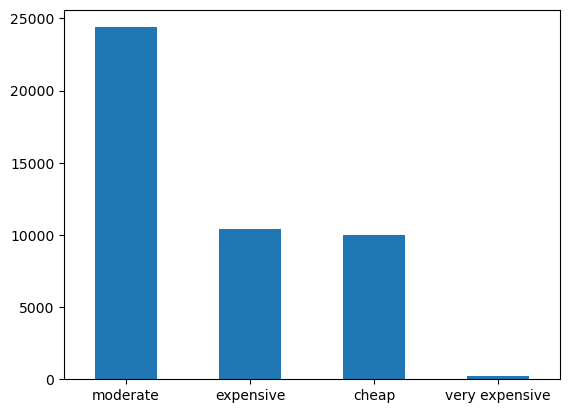

In [7]:
target_series = cars_train['Price Category'].value_counts()
target_series.plot.bar(x='Category', y='Count', rot=0)

In [8]:
cars_train = cars_train.drop(columns=['car_id'], axis='column')
cars_train.head(2)

,car-info,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment,Price Category
0,"[(90),(audi),(1986)]",with mileage,319999.0,PETROL,2200.0,gray,mechanics,front-wheel drive,D,cheap
1,"[(rapid),(skoda),(2016)]",with mileage,53000.0,petrol,1600.0,blue,mechanics,front-wheel drive,C,moderate


In [9]:
cars_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44995 entries, 0 to 44994
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car-info             44995 non-null  object 
 1   condition            44995 non-null  object 
 2   mileage(kilometers)  44995 non-null  float64
 3   fuel_type            44995 non-null  object 
 4   volume(cm3)          44960 non-null  float64
 5   color                44995 non-null  object 
 6   transmission         44995 non-null  object 
 7   drive_unit           43452 non-null  object 
 8   segment              40779 non-null  object 
 9   Price Category       44995 non-null  object 
dtypes: float64(2), object(8)
memory usage: 3.4+ MB


# Preprocessing

In [10]:
# Car Info Parsing
# تفكيك خاصية معلومات السيارة إلي مكونتها الثلاث: طراز و الشركة المُصّنعة و سنة الإنتاج
cars_train['car-model']           = cars_train['car-info'].apply(lambda str_pattern: hlp.extract_car_info_feature_x(str_pattern, x='model'))
cars_train['car-manufacturer']    = cars_train['car-info'].apply(lambda str_pattern: hlp.extract_car_info_feature_x(str_pattern, x='manufacturer'))
cars_train['car-production_year'] = cars_train['car-info'].apply(lambda str_pattern: hlp.extract_car_info_feature_x(str_pattern, x='production_year'))
cars_train = cars_train.drop(columns=['car-info'])

In [11]:
# PETROL is petrol!... تسوية الألفاظ المؤدية لذات المعني 
cars_train['fuel_type'] = cars_train['fuel_type'].apply(str.lower)

In [12]:
# Drop Choice <Make Decision>:: Why not "Imputation" ???
cars_train = cars_train.dropna(axis=0, how='any')

In [13]:
# Seprate Raw Features than Target Columns
Y_training_set = cars_train['Price Category']
X_training_set = cars_train.drop(columns=['Price Category'])

In [14]:
# رقمنة الفئات لتسهيل/لتمكين التعلم
# cars_Y.unique() # array(['cheap', 'moderate', 'expensive', 'very expensive'], dtype=object)
Y_training_set = Y_training_set.replace({'cheap': 0, 'moderate': 1, 'expensive': 2, 'very expensive': 3})

In [15]:
# Apply same Preprocessing folw "untill now" on Kaggle Testing set
X_testing_set = hlp.catch_up_testing(cars_test)

# Our Dillema
Kaggle Testing set provide new Categories not present on Training Set.

In [16]:
# hlp.ls_categories(X_training_set)
hlp.training_diff_testing(X_training_set, X_testing_set)

For Feature car-model; Training set DIFF Testing Set 32 Values : {'a4-allroad', 'hover-m4', 'traveller', 'range-rover-velar', 'c5-aircross', '205', 'focus-st', '967', 'x7', '2137', 'passat-alltrack', 'verso-s', 'cr-z', 'gls-amg', '9-2x', 'g-klass-amg', 'c-elysee', 'gl-klass-amg', 'c4-cactus', 'cls-amg', '159', 'clio-rs', 'a2', 'x5m', 'c4-aircross', 's90', '90', 'cla-amg', '2112', 'gla-amg', 'cl-amg', '2138'}
For Feature car-production_year; Training set DIFF Testing Set 6 Values : {'1910', '1960', '1965', '1970', '1959', '1958'}


In [17]:
# hlp.ls_categories(X_testing_set)
hlp.testing_diff_training(X_training_set, X_testing_set)

For Feature car-model; Testing set DIFF Training Set 3 Values : {'a19', 's7', 'town-car'}
For Feature car-manufacturer; Testing set DIFF Training Set 1 Values : {'lincoln'}
For Feature car-production_year; Testing set DIFF Training Set 1 Values : {'1957'}


In [18]:
X_training_set, X_testing_set = hlp.mirroring(X_training_set, X_testing_set)

In [19]:
X_training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39383 entries, 0 to 44994
Columns: 610 entries, mileage(kilometers) to car-model_s7
dtypes: float64(2), int64(5), uint8(603)
memory usage: 25.1 MB


In [20]:
X_testing_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9840 entries, 0 to 11248
Columns: 610 entries, mileage(kilometers) to car-model_s7
dtypes: float64(2), int64(38), uint8(570)
memory usage: 8.4 MB


In [21]:
# Standardize Numerical Feature
ss = StandardScaler()
scaled_features = ss.fit_transform(X_training_set[["mileage(kilometers)", "volume(cm3)"]])
X_training_set[["mileage(kilometers)", "volume(cm3)"]] = scaled_features.tolist()

### Testing Transformation ONLY

In [22]:
scaled_features = ss.transform(X_testing_set[["mileage(kilometers)", "volume(cm3)"]])
X_testing_set[["mileage(kilometers)", "volume(cm3)"]] = scaled_features.tolist()

In [23]:
print(f'NO. of Dimensions: {len(X_training_set.iloc[0,::])}')

NO. of Dimensions: 610


In [24]:
# البيانات الأن
# X_train.head(3)
# X_test.head(3)

## Dimensionality Reduction

In [25]:
pca = PCA(0.95)    # choose the minimum number of principal components such that 95% of the variance is retained.
X_train_pca_transformed = pca.fit_transform(X_training_set)

In [26]:
X_train_pca_transformed = pd.DataFrame(data=X_train_pca_transformed)

In [27]:
print(f'NO. of Dimensions After PCA: {len(X_train_pca_transformed.iloc[0,::])}')

NO. of Dimensions After PCA: 144


In [28]:
# pca.explained_variance_ratio_

### Testing Transformation ONLY

In [29]:
# OLLY Transformation on Kaggle Testing set
X_test_pca_transformed = pca.transform(X_testing_set)

# Train Test Splitting

In [30]:
# Decision is made here:: الداتا المُدرِبة تلك التي خفّضت أبعادها
X_train, X_test, y_train, y_test = train_test_split(X_training_set, Y_training_set, test_size=0.2, random_state=42)

# Hinge Loss Model - Hyper Parameter Tuning

In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

classifier = SGDClassifier(random_state=42)

parameters = {'alpha':[0.0001, 0.001, 0.01, 0.1],
             'loss':['hinge']}
grid = GridSearchCV(classifier, parameters, cv=10)
grid.fit(X_train, y_train)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))
# ==
print("Best CV params", grid.best_params_)
print("Train accuracy of best grid search hypers:", grid.score(X_train, y_train))
print("Test accuracy of best grid search hypers:", grid.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1706
           1       0.87      0.91      0.89      4295
           2       0.90      0.82      0.86      1839
           3       0.67      0.05      0.10        37

    accuracy                           0.87      7877
   macro avg       0.82      0.66      0.67      7877
weighted avg       0.87      0.87      0.87      7877

Best CV params {'alpha': 0.0001, 'loss': 'hinge'}
Train accuracy of best grid search hypers: 0.8777375737954676
Test accuracy of best grid search hypers: 0.8726672591087977


# SVC Model  

In [32]:
from sklearn.svm import SVC

model = SVC()
start = time() 
model.fit(X_train, y_train)
end = time() 
print(f'Train Time {end - start} s')

start = time()
predictions = model.predict(X_test)
end = time()
print(f'Prediction Time {end - start} s')
print(classification_report(y_test, predictions))

print("Training accuracy (SVM):", model.score(X_train, y_train))
print("Testing accuracy (SVM):", model.score(X_test, y_test))

Train Time 173.44514536857605 s
Prediction Time 58.633031606674194 s
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1706
           1       0.90      0.91      0.91      4295
           2       0.91      0.88      0.89      1839
           3       0.94      0.46      0.62        37

    accuracy                           0.89      7877
   macro avg       0.90      0.78      0.82      7877
weighted avg       0.89      0.89      0.89      7877

Training accuracy (SVM): 0.9122071986288326
Testing accuracy (SVM): 0.894249079598832


# Ensemble Methods (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100)

start = time() 
RF.fit(X_train, y_train)
end = time() 
print(f'Train Time {end - start} s')

start = time()
test_pred_forrest = RF.predict(X_test)
end = time()
print(f'Prediction Time {end - start} s')

print(classification_report(y_test, test_pred_forrest))
print("Train accuracy of Random_forest:", RF.score(X_train, y_train))
print("Test accuracy of Random_forest:", RF.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1706
           1       0.88      0.91      0.89      4295
           2       0.90      0.86      0.88      1839
           3       0.93      0.35      0.51        37

    accuracy                           0.88      7877
   macro avg       0.89      0.74      0.78      7877
weighted avg       0.88      0.88      0.88      7877

Train accuracy of Random_forest: 0.9993017203072431
Test accuracy of Random_forest: 0.8797765646819855


# Random Forest Ensemble with PCA Transformed X Train

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_train_pca_transformed, Y_training_set, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100)

RF.fit(X_train_pca, y_train_pca)
test_pred_forrest = RF.predict(X_test_pca)

print(classification_report(y_test_pca, test_pred_forrest))
print("Train accuracy of Random_forest on PCA Transformed Training:", RF.score(X_train_pca, y_train_pca))
print("Test accuracy of Random_forest on PCA Transformed Training:", RF.score(X_test_pca, y_test_pca))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1706
           1       0.88      0.91      0.89      4295
           2       0.90      0.87      0.88      1839
           3       0.88      0.38      0.53        37

    accuracy                           0.88      7877
   macro avg       0.88      0.75      0.79      7877
weighted avg       0.88      0.88      0.88      7877

Train accuracy of Random_forest on PCA Transformed Training: 0.9992699803212086
Test accuracy of Random_forest on PCA Transformed Training: 0.8787609496001015


# Grid Search Parameter Fine Tunining stacked over PCA Feature Reduction on Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state = 42)
print(f'Model {dt.__class__.__name__} Without niether PCA applied nor Parameter Search for Optimal')

start = time() 
learner = dt.fit(X_train, y_train) 
end = time() 
print(f'Train Time {end - start} s')
    
start = time()
predictions_test = learner.predict(X_test)
predictions_train = learner.predict(X_train)
end = time()
print(f'Prediction Time {end - start} s')

print(classification_report(y_test, predictions_test))
print(f'Training Accuracy Score {accuracy_score(y_train, predictions_train)}')
print(f'Testing Accuracy Score {accuracy_score(y_test, predictions_test)}')

Model DecisionTreeClassifier
Train Time 2.036262035369873 s
Prediction Time 0.10638070106506348 s
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1706
           1       0.85      0.86      0.86      4295
           2       0.84      0.83      0.84      1839
           3       0.68      0.73      0.70        37

    accuracy                           0.84      7877
   macro avg       0.79      0.80      0.80      7877
weighted avg       0.84      0.84      0.84      7877

Training Accuracy Score 0.9993017203072431
Testing Accuracy Score 0.8387711057509204


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dc_tree = DecisionTreeClassifier(random_state = 42)
print(f'Model {dt.__class__.__name__}')

params =  {
    'min_samples_leaf': [30, 40, 50],
    'max_depth': [7, 10, 15]
}

grid = GridSearchCV(estimator=dc_tree,
                    param_grid=params,
                    cv=10,
                    n_jobs=1)
start = time() 
grid.fit(X_train_pca, y_train_pca)
end = time() 
print(f'Train Time {end - start} s')

start = time() 
grid_predictions = grid.predict(X_test_pca)
end = time() 
print(f'Prediction Time {end - start} s')

Model DecisionTreeClassifier
Train Time 705.928329706192 s
Prediction Time 0.009691238403320312 s


In [ ]:
print(classification_report(y_test_pca, grid_predictions))
print(f'Best CV params {grid.best_params_}')
print("Train accuracy of best grid search hypers:", grid.score(X_train_pca, y_train_pca))
print("Test accuracy of best grid search hypers:", grid.best_score_)

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1706
           1       0.82      0.87      0.84      4295
           2       0.80      0.76      0.78      1839
           3       0.00      0.00      0.00        37

    accuracy                           0.81      7877
   macro avg       0.60      0.59      0.60      7877
weighted avg       0.81      0.81      0.81      7877

Best CV params {'max_depth': 15, 'min_samples_leaf': 30}
Train accuracy of best grid search hypers: 0.8490763664063988
Test accuracy of best grid search hypers: 0.8034658788089445


/home/ahmed/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ahmed/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ahmed/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'DecisionTreeClassifier')

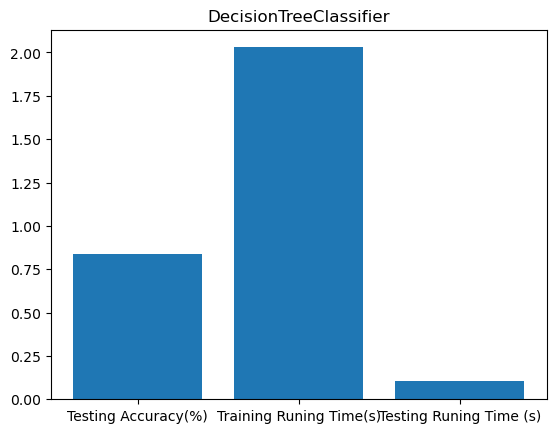

In [35]:
import matplotlib.pyplot as plt
models = ['Testing Accuracy(%)', 'Training Runing Time(s)', 'Testing Runing Time (s)']
accuracies_bar = [0.838, 2.03, 0.106]
plt.bar(models, accuracies_bar)
plt.title("DecisionTreeClassifier")

Text(0.5, 1.0, 'SVM')

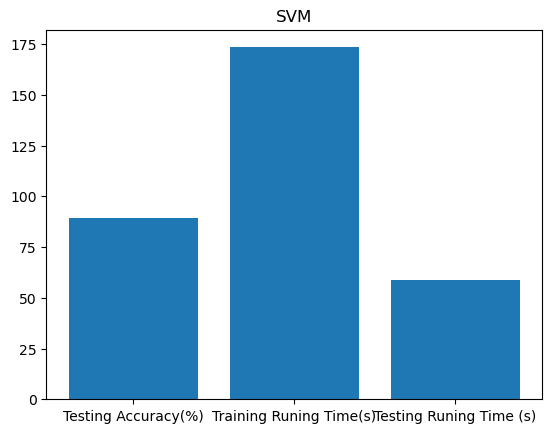

In [34]:
import matplotlib.pyplot as plt
models = ['Testing Accuracy(%)', 'Training Runing Time(s)', 'Testing Runing Time (s)']
accuracies_bar = [0.894*100, 173.4, 58.63]
plt.bar(models, accuracies_bar)
plt.title("SVM")

# Model Testing Predictions and Kaggle Submission
